## 字数统计任务隐藏状态参数可视化分析

## 数据可视化处理

#### 针对当前数据文件结构，设计一个用于取用数据的类

In [1]:
import os
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import clear_output
from config_parse import VisualConfig
visualconfig = VisualConfig("./visual_config.json")

class HidDataFetch():
    def __init__(self, hid_datas_path, task_pattern) -> None:
        self.config = visualconfig
        self.task_pattern = task_pattern
        self.hid_datas_path = hid_datas_path
        self.dialogues_num = self.count_dirs(self.hid_datas_path)
        print("dialogues_num:", self.dialogues_num)
        self.task_prompts = None
        self.dialogues = []
        self.tag_list = []
        self.datas = []
        self.fetch_all_dialogues()
        self.init_tags()
        self.init_task_prompts()
        # self.fetch_all_datas()

    # 加载所有种类的任务描述
    def init_task_prompts(self):
        with open(self.config.role_setting_prompt_json, 'r', encoding='utf-8') as f:
            role_setting_prompts = json.load(f)
        self.task_prompts = role_setting_prompts[self.task_pattern]

    # 获取特定序号任务的task_prompt序号
    def get_task_prompt_index(self, index):
        tmp_task_prompt = self.dialogues[index]['dialogues'][0]["content"]
        return self.task_prompts.index(tmp_task_prompt)
    
    # 获取全部任务的task_prompt序号列表
    def get_all_task_prompt_index(self):
        tmp_task_prompts = []
        for i in range(self.dialogues_num):
            tmp_task_prompts.append(self.get_task_prompt_index(i))
        return tmp_task_prompts

    # 将所有dialogue.txt读取整合
    def fetch_all_dialogues(self):
        for i in range(self.dialogues_num):
            self.dialogues.append(self.load_dialogue_by_index(i))
    # 将所有隐藏状态参数读取整合
    def fetch_all_datas(self):
        for i in range(self.dialogues_num):
            self.datas.append(self.load_data_by_index(i))

    # 读取对应index的dialogue.txt
    def load_dialogue_by_index(self, index):
        with open(self.hid_datas_path + "/" + str(index) + "/dialogue.txt", "r", encoding="utf-8") as f:
            dialogue = json.load(f)

    # 提取出所有的tag
    def init_tags(self):
        for diagolue in self.dialogues:
            self.tag_list.append(diagolue['tag'])

    # 统计文件夹中下有多少文件和文件夹
    def count_dirs(self, path):
        return len(os.listdir(path))
    
    # 从硬盘中读取对应的dialogue.txt
    def load_dialogue_by_index(self, index):
        if index >= self.dialogues_num:
            print("index out of range")
            return None
        hid_data_path = os.path.join(self.hid_datas_path, str(index), 'dialogue.txt')
        # print(hid_data_path)
        hid_data = {}
        with open(hid_data_path, 'r', encoding='utf-8') as f:
            hid_data = json.load(f)
        return hid_data
    
    # 获取某index对应的完整的dialogue.txt
    def fetch_by_index(self, index):
        return self.dialogues[index]
    
    # 获取某index的tag
    def fetch_tag_by_index(self, index):
        if index >= self.dialogues_num:
            print("index out of range")
            return None
        return self.dialogues[index]['tag']
    
    # 获取某index对应的完整的对话内容
    def fetch_dialogue_by_index(self, index):
        if index >= self.dialogues_num:
            print("index out of range")
            return None
        return self.dialogues[index]['dialogues']

    # 获取符合某个tag的所有index
    def fetch_index_list_by_tag(self, tag):
        return [index for index in range(self.dialogues_num) if self.dialogues[index]['tag'] == tag]

    # 获取某个index下的所有data
    def load_data_by_index(self, index):
        data_dir_path = os.path.join(self.hid_datas_path, str(index))
        datas = []
        for file in sorted(os.listdir(data_dir_path)):
            if file.endswith(".npz"):
                data_path = os.path.join(data_dir_path, file)
                data_f = np.load(data_path)
                datas.append(np.array(list(data_f.values())))
                data_f.close()
        return datas
    
    # 获取某个index下的特定的data
    def load_special_data(self, path_index, round, speaker, file_index):
        filename = self.get_special_filename(path_index, round, speaker, file_index)
        data_dir_path = os.path.join(self.hid_datas_path, str(path_index))
        data_path = os.path.join(data_dir_path, filename)
        data_f = np.load(data_path)
        datas = np.array(list(data_f.values()))
        data_f.close()
        return datas
    
    # 获取特定隐藏层的file_index
    def get_special_filename(self, path_index, round, speaker, file_index):
        data_dir_path = os.path.join(self.hid_datas_path, str(path_index))
        filename_list = []
        user_filename_list = []
        assistant_filename_list = []
        tmp_round = 0
        for file in sorted(os.listdir(data_dir_path)):
            if file.endswith(".npz"):
                filename_list.append(file)
        base_size = os.path.getsize(os.path.join(data_dir_path, filename_list[1]))
        for file in filename_list:
            file_size = os.path.getsize(os.path.join(data_dir_path, file))
            if file_size > base_size:
                user_filename_list.append([file])
                tmp_round = tmp_round + 1
            else:
                if tmp_round > len(assistant_filename_list): 
                    assistant_filename_list.append([file])
                else:
                    assistant_filename_list[tmp_round-1].append(file)
        if speaker == "user":
            return user_filename_list[round][file_index]
        elif speaker == "assistant":
            return assistant_filename_list[round][file_index]
        else:
            return 0
    
    # 获取user输入文本开始对应的index
    def get_use_text_index_by_index(self, index):
        user_index_list = [index for index, element in enumerate(self.load_data_by_index(index)) if element.shape[1] > 1]
        return user_index_list
        
    # 分情况载入特定数据
    def load_one_state_by_special_position(self, index, round, speaker, token_index_range):
        if speaker == "user":
            if type(token_index_range) is int:
                tmp_data = self.load_special_data(index,round,speaker,0)[:, token_index_range, :, :].reshape(29, 4096)
            else:
                tmp_data = self.load_special_data(index,round,speaker,0)[:, token_index_range[0]:token_index_range[1]:, :, :].reshape(29, token_index_range[1]-token_index_range[0],4096)
                tmp_data = np.transpose(tmp_data, (1, 0, 2))
        elif speaker == "assistant":
            if type(token_index_range) is int:
                tmp_data = self.load_special_data(index,round,speaker,token_index_range).reshape(29, 4096)
            else:
                tmp_data = self.load_special_data(index, round, speaker, token_index_range[0]).reshape(1, 29, 4096)
                for i in range(token_index_range[0]+1, token_index_range[1]):
                    tmp_data = np.concatenate((tmp_data, self.load_special_data(index,round,speaker,i).reshape(1, 29, 4096)), axis=0)
        tmp_label = str(self.fetch_tag_by_index(index))
        return index, tmp_data, tmp_label  # 返回索引和数据
    
    # 获取全部数据中特定位置（最后一次用户输入后）的特定隐藏层参数
    def load_all_state_by_special_position(self, round, speaker, token_index_range):


        # 初始化列表
        datas = [None] * len(self.dialogues)
        labels = [None] * len(self.dialogues)
        count = 0
        with ThreadPoolExecutor(max_workers=64) as executor:
            futures = [executor.submit(self.load_one_state_by_special_position, i, round, speaker, token_index_range) for i in range(len(self.dialogues))]
            total_dialogues = len(self.dialogues)
            for future in as_completed(futures):
                i, tmp_data, tmp_label = future.result()
                datas[i] = tmp_data  # Use the index to insert at the correct position
                labels[i] = tmp_label
                count += 1
                # Calculate the percentage of completion
                percent_complete = (count / total_dialogues) * 100
                # Print the real-time percentage progress
                if count % 10 == 0:
                    clear_output(wait=True)
                    print(f"Progress: {percent_complete:.2f}% Complete ({count}/{total_dialogues})")

        return datas, labels
    




#### 加载数据

In [2]:
trans_data_fetcher = HidDataFetch("./datas/translator", "translator")
count_data_fetcher = HidDataFetch("./datas/counter", "counter")

dialogues_num: 1034
dialogues_num: 1000


In [3]:
trans_datas,trans_labels = trans_data_fetcher.load_all_state_by_special_position(-1, 'user', -1)
count_datas,count_labels= count_data_fetcher.load_all_state_by_special_position(-1, 'user', -1)

Progress: 100.00% Complete (1000/1000)


In [4]:
trans_task_kind_list = trans_data_fetcher.get_all_task_prompt_index()
count_task_kind_list = count_data_fetcher.get_all_task_prompt_index()

#### 获取目标数据

在这里，我们首先尝试获取了所有任务中，用户将最后一次任务完整输入后，最后一层transformer隐藏层的输出。

In [5]:
# 只取最后一层隐藏层输出
trans_datas_layer29 = np.array([data[28] for data in trans_datas])
count_datas_layer29 = np.array([data[28] for data in count_datas])

In [10]:
# 获取labels，没能够成功识别的，默认为正确完成翻译任务
trans_labels_int = np.array([int(y) if y=='0' or y=='1' else 0  for y in trans_labels])
count_labels_int = np.array([int(y)+2 if y=='0' or y=='1' else 2  for y in count_labels])
trans_task_kind_list_int = np.array([int(y) for y in trans_task_kind_list])
count_task_kind_list_int = np.array([int(y)+10 for y in count_task_kind_list])

In [9]:
count_task_kind_list+10

TypeError: can only concatenate list (not "int") to list

In [11]:
datas_layer29 = np.concatenate((trans_datas_layer29, count_datas_layer29), axis=0)
labels_int = np.concatenate((trans_labels_int, count_labels_int), axis=0)
task_kind_list = np.concatenate((trans_task_kind_list_int, count_task_kind_list_int), axis=0)

In [12]:
len(labels_int)

2034

#### 尝试t-SNE降维到三维

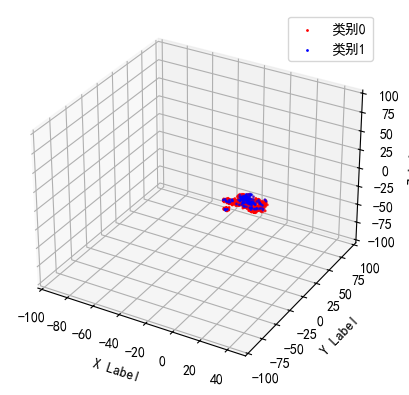

In [11]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif']=['SimHei'] # 设置字体为黑体，解决Matplotlib中文乱码问题

plt.rcParams['axes.unicode_minus']=False # 解决Matplotlib坐标轴负号'-'显示为方块的问题

# 假设您的输入数据是一个名为data的numpy数组，形状是(29, 4096)
# 假设labels是标签数组

# 应用t-SNE降维到三维
tsne = TSNE(n_components=3, random_state=42)
data_tsne = tsne.fit_transform(np.array(datas_layer29))

# 可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 假设您有两个标签类别，用0和1表示
ax.scatter(data_tsne[labels_int == 0, 0], data_tsne[labels_int == 0, 1], data_tsne[labels_int == 0, 2], c='r', s=1,label='类别0')
ax.scatter(data_tsne[labels_int == 1, 0], data_tsne[labels_int == 1, 1], data_tsne[labels_int == 1, 2], c='b', s=1,label='类别1')

plt.xlim(-100, 50)
plt.ylim(-100, 100)
ax.set_zlim(-100, 100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()

plt.show()

In [68]:
len(datas_layer29)

1034

In [33]:
# 统计labels_int中0的个数和1的个数
nums_0 = len(labels_int[labels_int==0])
nums_1 = len(labels_int[labels_int==1])

#### 应用t-SNE降维到三维

In [14]:
# 自由视角的三维图
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# 假设您的输入数据是一个名为data的numpy数组，形状是(29, 4096)
# 假设labels是标签数组

# 应用t-SNE降维到三维
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
data_tsne = tsne.fit_transform(datas_layer29)

# 将降维后的数据和标签转换为DataFrame
df = pd.DataFrame(data_tsne, columns=['x', 'y', 'z'])
df['label'] = labels_int.astype(str)  # 添加标签列
df['task_prompt_kind'] = task_kind_list.astype(str)
df['data_id'] = np.array(range(len(datas_layer29)))

# 创建一个颜色映射字典，这里0对应红色，1对应蓝色
color_map = {0: '0', 1: '1', 2: '2', 3: '3'}

# 将标签数组映射到颜色
colors = [color_map[label] for label in labels_int]

# 使用Plotly创建交互式三维散点图
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='label', 
                    labels={'label': 'Label'},
                    # color_discrete_map={"0": "red", "1": "green","2": "blue", "3":"yellow"},
                    hover_data=['label','data_id'],
                    title='t-SNE 3D Visualization')
fig.update_traces(marker=dict(size=3))
# fig.show()
fig.show(renderer="browser")

#### 应用主成分分析（PCA）降维到三维

In [34]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# 假设您的输入数据是一个名为datas_layer29的numpy数组，形状是(29, 4096)
# 假设labels_int是标签数组

# 应用PCA降维到三维
pca = PCA(n_components=3, random_state=42)
data_pca = pca.fit_transform(datas_layer29)

# 将降维后的数据和标签转换为DataFrame
df = pd.DataFrame(data_pca, columns=['x', 'y', 'z'])
df['label'] = labels_int.astype(str)  # 添加标签列

# 创建一个颜色映射字典，这里0对应红色，1对应蓝色
# color_map = {"0": "red", "1": "green","2": "blue", "3":"yellow"}
# color_map = {0: 'blue', 1: 'red'}
# 将标签数组映射到颜色
# colors = [color_map[label] for label in labels_int]

# 使用Plotly创建交互式三维散点图
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='label', 
                    labels={'label': 'Label'},
                    # color_discrete_map={"0": "red", "1": "green","2": "blue", "3":"yellow"},
                    hover_data=['label'],
                    title='PCA 3D Visualization')
fig.update_traces(marker=dict(size=3))
# fig.show()
fig.show(renderer="browser")


#### 应用多维缩放（MDS）降维到三维

In [17]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.manifold import MDS

# 假设您的输入数据是一个名为datas_layer29的numpy数组，形状是(29, 4096)
# 假设labels_int是标签数组

# 应用MDS降维到三维
mds = MDS(n_components=3, random_state=42)
data_mds = mds.fit_transform(datas_layer29)

# 将降维后的数据和标签转换为DataFrame
df = pd.DataFrame(data_mds, columns=['x', 'y', 'z'])
df['label'] = labels_int  # 添加标签列

# 创建一个颜色映射字典，这里0对应红色，1对应蓝色
color_map = {0: '0', 1: '1', 2: '2', 3: '3'}

# 将标签数组映射到颜色
colors = [color_map[label] for label in labels_int]

# 使用Plotly创建交互式三维散点图
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color=colors, labels={'label': 'Label'},
                    title='MDS 3D Visualization')
fig.update_traces(marker=dict(size=3))
# fig.show()
fig.show(renderer="browser")

d:\Anaconda3\envs\data_analyse\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



In [66]:
type(labels_int)

list

In [64]:
data_tsne[labels_int == 0, 0]

array([], shape=(0, 1034, 3), dtype=float32)